In [ ]:
import ijson
import numpy as np
import json
from decimal import Decimal
import json
import time
import torch
import warnings
import pennylane as qml
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
import json
import numpy as np
from sklearn.model_selection import train_test_split
import pennylane as qml
import torch
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

In [ ]:


def cargar_datos_json(json_path, num_jets=10000, num_constituents=10):
    with open(json_path, 'r') as f:
        data = json.load(f)

    eventos = []
    for i, evento in enumerate(data[:num_jets]):
        # Extract jet kinematics
        jet_pt = evento.get('jet_pt', i)
        jet_eta = evento.get('jet_eta', i)
        jet_phi = evento.get('jet_phi', i)
        jet_mass = evento.get('jet_sdmass', i)
        jet_energy = evento.get('jet_energy', i)
        jet_tau1 = evento.get('jet_tau1', i)
        jet_tau2 = evento.get('jet_tau2', i)
        jet_tau3 = evento.get('jet_tau3', i)    
        jet_tau4 = evento.get('jet_tau4', i)

        jet_tau12 = jet_tau1 / jet_tau2 if jet_tau2 != 0 else 0
        jet_tau23 = jet_tau2 / jet_tau3 if jet_tau3 != 0 else 0
        jet_tau34 = jet_tau3 / jet_tau4 if jet_tau4 != 0 else 0

        # Extract constituents (particles)
        part_px = np.array(evento.get('part_px', []))
        part_py = np.array(evento.get('part_py', []))
        part_pz = np.array(evento.get('part_pz', []))
        part_energy = np.array(evento.get('part_energy', []))
        part_d0val = np.array(evento.get('part_d0val', []))
        part_dzval = np.array(evento.get('part_dzval', []))
        
        # Calculate pT, eta, phi, mass for each constituent
        pt = np.sqrt(part_px**2 + part_py**2)
        p_total = np.sqrt(part_px**2 + part_py**2 + part_pz**2)
        eta = 0.5 * np.log((p_total + part_pz) / (p_total - part_pz + 1e-8))  # Avoiding dividing by 0
        phi = np.arctan2(part_py, part_px)
        mass = np.sqrt(np.maximum(0, part_energy**2 - (part_px**2 + part_py**2 + part_pz**2)))
        
        # Seleccionar los num_constituents con mayor pt
        indices_ordenados = np.argsort(pt)[::-1][:num_constituents]
        
        top_constituents = []
        for idx in indices_ordenados:
            top_constituents.append({
                'pt': pt[idx],
                'eta': eta[idx],
                'phi': phi[idx],
                'px': part_px[idx],
                'py': part_py[idx],
                'pz': part_pz[idx],
                'mass': mass[idx],
                'energy': part_energy[idx],
                'd0': part_d0val[idx],
                'dz': part_dzval[idx]
            })
            
        eventos.append({
            'pt_jet': jet_pt,
            'eta_jet': jet_eta,
            'phi_jet': jet_phi,
            'mass_jet': jet_mass,
            'energy_jet': jet_energy,
            'tau1_jet': jet_tau1,
            'tau2_jet': jet_tau2,
            'tau3_jet': jet_tau3,
            'tau4_jet': jet_tau4,
            'tau12_jet': jet_tau12,
            'tau23_jet': jet_tau23,
            'tau34_jet': jet_tau34,
            'constituents': top_constituents
        })

    return eventos
# Ejemplo de uso
datos_HToBB = cargar_datos_json('./HToBB_120_flat.json', num_jets=10000, num_constituents=10)
datos_TTBar = cargar_datos_json('./TTBar_120_flat.json', num_jets=10000, num_constituents=10)
datos_WToqq = cargar_datos_json('./WToQQ_120_flat.json', num_jets=10000, num_constituents=10)
datos_QCD_simu_1 = cargar_datos_json('/Volumes/usb_MCarou/ZJetsToNuNu_120_flat.json', num_jets=22500, num_constituents=10)
datos_QCD_simu_2 = cargar_datos_json('/Volumes/usb_MCarou/ZJetsToNuNu_120_flat.json', num_jets=22500, num_constituents=10)
datos_QCD_simu_full = datos_QCD_simu_1 + datos_QCD_simu_2

In [ ]:
datos = np.array(datos_QCD_simu_full)

# Separar 10,000 para entrenamiento y 12,500 restantes
X_train, X_temp = train_test_split(
    datos, 
    train_size=10000, 
    random_state=42, 
    shuffle=True
)

# Separar 2,500 para validación y 10,000 para inferencia
X_val, rest = train_test_split(
    X_temp, 
    train_size=2500, 
    random_state=42, 
    shuffle=True
)

X_inf, rest = train_test_split(
    rest, 
    train_size=10000, 
    random_state=42, 
    shuffle=True
)

# Verificar tamaños
print(f"Entrenamiento: {len(X_train)}")
print(f"Validación: {len(X_val)}")
print(f"Inferencia: {len(X_inf)}")

In [ ]:
# --- Parámetros del circuito ---
num_particles = 10
num_latent = 2
num_ref = num_particles - num_latent
num_trash = num_ref
wires = list(range(num_particles + num_ref + 1))  # +1 ancilla
ancilla = wires[-1]
dev = qml.device("default.qubit", wires=wires)

latent_wire = 0
trash_wires = wires[1:num_particles]
ref_wires = wires[num_particles:-1]


# --- Codificación 1P1Q (misma que en el paper) ---
def f(w):
    return 1 + (2 * np.pi / (1 + torch.exp(-w)))

def phi_circuit(w, phi, phi_jet, pt, pt_jet):
    return f(w) * pt / pt_jet * (phi - phi_jet)

def theta_circuit(w, eta, eta_jet, pt, pt_jet):
    return f(w) * pt / pt_jet * (eta - eta_jet)

def tau1_circuit(w, tau1_jet, pt, pt_jet):
    return f(w) * pt / pt_jet * (tau1_jet)

def tau2_circuit(w, tau2_jet, pt, pt_jet):
    return f(w) * pt / pt_jet * (tau2_jet)


# --- Encoder 1P1Q adaptado al nuevo formato de jet ---
def encode_1p1q(jet, w):
    pt_jet = jet['pt_jet']
    eta_jet = jet['eta_jet']
    phi_jet = jet['phi_jet']
    constituents = jet['constituents']

    for i in range(num_particles):
        c = constituents[i]
        theta = theta_circuit(w, c['eta'], eta_jet, c['pt'], pt_jet)
        phi = phi_circuit(w, c['phi'], phi_jet, c['pt'], pt_jet)
        #tau1 = tau1_circuit(w, jet['tau1_jet'], c['pt'], pt_jet)
        #tau2 = tau2_circuit(w, jet['tau2_jet'], c['pt'], pt_jet)
        qml.RY(theta, wires=i)
        qml.RX(phi, wires=i)
        #qml.RY(tau1, wires=i)
        #qml.RX(tau2, wires=i)


# --- Capa variacional ---
def variational_layer(theta_i, phi_i, w_i, num_layers):
    for layer in range(num_layers):
        for i in range(num_particles):
            for j in range(i + 1, num_particles):
                qml.CNOT(wires=[i, j])

        for i in range(num_particles):
            qml.RX(phi_i[layer, i], wires=i)
            qml.RZ(theta_i[layer, i], wires=i)
            qml.RY(w_i[layer, i], wires=i)


# --- QAE Circuit ---
@qml.qnode(dev, interface="torch", diff_method="backprop")
def qae_circuit(jet, w, theta_i, phi_i, w_i, num_layers):
    encode_1p1q(jet, w)
    variational_layer(theta_i, phi_i, w_i, num_layers)

    for trash_wire, ref_wire in zip(trash_wires, ref_wires):
        qml.Hadamard(wires=ancilla)
        qml.CSWAP(wires=[ancilla, trash_wire, ref_wire])
        qml.Hadamard(wires=ancilla)

    return qml.probs(wires=ancilla)


# --- Cost function para entrenamiento ---
def cost_function_with_fidelity(jet, w, theta_i, phi_i, w_i, num_layers):
    prob_0 = qae_circuit(jet, w, theta_i, phi_i, w_i, num_layers)[0]
    fidelity = prob_0
    return -fidelity, fidelity.item()

def encontrar_maximos_per_jet(jet):
    max_pt = jet['pt_jet']
    max_eta = jet['eta_jet']
    max_phi = jet['phi_jet']
    return max_pt, max_eta, max_phi


In [ ]:
# Hacer 100 veces 

fil_100_back = []
fil_100_HToBB = []
fil_100_WToQQ = []
fil_100_TTBar = []



# --- Parámetros del circuito ---
num_particles = 4
num_latent = 1
num_ref = num_particles - num_latent
num_trash = num_ref
wires = list(range(num_particles + num_ref + 1))  # +1 ancilla
ancilla = wires[-1]
dev = qml.device("default.qubit", wires=wires)

latent_wire = 0
trash_wires = wires[1:num_particles]
ref_wires = wires[num_particles:-1]

for i in range(100):

    w = torch.tensor(1.0, requires_grad=True)
    num_layers = 1 # Number of variational layers
    theta_i = (torch.rand(num_layers, num_particles) * 2 * torch.pi).requires_grad_(True)
    phi_i   = (torch.rand(num_layers, num_particles) * 2 * torch.pi).requires_grad_(True)
    w_i     = (torch.rand(num_layers, num_particles) * 2 * torch.pi).requires_grad_(True)
    optimizer = torch.optim.Adam(
        [w, theta_i, phi_i, w_i],
        lr=5e-2,              
        betas=(0.5, 0.999),
        eps=1e-08,
        weight_decay=0.0,    
        amsgrad=True          
    )
    num_epochs = 1
    all_fidelities = []
    event_fidelities = []  # List to store event fidelities

    for epoch in range(num_epochs):
        total_loss = 0.0
        epoch_fidelities = []
        avg_fidelity = 0.0
        avg_loss = 0.0
        
        for jet in X_train:
            if len(jet['constituents']) < num_particles:
                continue
        
            loss, fidelity = cost_function_with_fidelity(jet, w, theta_i, phi_i, w_i,  num_layers)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            epoch_fidelities.append(fidelity)
            event_fidelities.append(fidelity * 100)  # in %

        avg_loss = total_loss / len(epoch_fidelities)
        avg_fidelity = np.mean(epoch_fidelities) * 100
        all_fidelities.append(avg_fidelity)


    event_fidelities_back = []
    event_fidelities_HToBB = []
    event_fidelities_WToQQ = []
    event_fidelities_TTBar = []
    fidelidades = []
    etiquetas = []

    
    for jet in X_inf:
        if len(jet['constituents']) < num_particles:
            continue
        _, fidelity = cost_function_with_fidelity(jet, w, theta_i, phi_i, w_i, num_layers)
        event_fidelities_back.append(fidelity * 100) 
        fidelidades.append(fidelity)
        etiquetas.append(0)

    

    inicio = time.time()
    for jet in datos_HToBB:
        if len(jet['constituents']) < num_particles:
            continue
        _, fidelity = cost_function_with_fidelity(jet, w, theta_i, phi_i, w_i, num_layers)
        event_fidelities_HToBB.append(fidelity * 100) 
        fidelidades.append(fidelity)
        etiquetas.append(1)

    

    for jet in datos_TTBar:
        if len(jet['constituents']) < num_particles:
            continue
        _, fidelity = cost_function_with_fidelity(jet, w, theta_i, phi_i, w_i, num_layers)
        event_fidelities_TTBar.append(fidelity * 100) 
        fidelidades.append(fidelity)
        etiquetas.append(1)

    

    for jet in datos_WToqq:
        if len(jet['constituents']) < num_particles:
            continue
        _, fidelity = cost_function_with_fidelity(jet, w, theta_i, phi_i, w_i, num_layers)
        event_fidelities_WToQQ.append(fidelity * 100) 
        fidelidades.append(fidelity)
        etiquetas.append(1)

    

    fil_100_back.append(event_fidelities_back)
    fil_100_HToBB.append(event_fidelities_HToBB)
    fil_100_WToQQ.append(event_fidelities_WToQQ)
    fil_100_TTBar.append(event_fidelities_TTBar)

    print("Fin etapa ", i+1)

In [ ]:


fil_100_back_qubits=fil_100_back,
fil_100_HToBB_qubits=fil_100_HToBB,
fil_100_WToQQ_qubits=fil_100_WToQQ,
fil_100_TTBar_qubits=fil_100_TTBar

np.savez(
    'fidelidades_100_QUBITS.npz',
    fil_100_back_S=fil_100_back_qubits,
    fil_100_HToBB_S=fil_100_HToBB_qubits,
    fil_100_WToQQ_S=fil_100_WToQQ_qubits,
    fil_100_TTBar_S=fil_100_TTBar_qubits
)
print("Guardado como fidelidades_100_QUBITS.npz")

In [59]:
data = np.load('./fidelidades_100_QUBITS.npz', allow_pickle=True)
fil_100_back_3= data['fil_100_back_S']
fil_100_HToBB_3 = data['fil_100_HToBB_S']
fil_100_WToQQ_3 = data['fil_100_WToQQ_S']
fil_100_TTBar_3 = data['fil_100_TTBar_S']

fil_100_back_3 = fil_100_back_3.squeeze()
fil_100_HToBB_3 = fil_100_HToBB_3.squeeze()
fil_100_WToQQ_3 = fil_100_WToQQ_3.squeeze()
fil_100_TTBar_3 = fil_100_TTBar_3.squeeze()


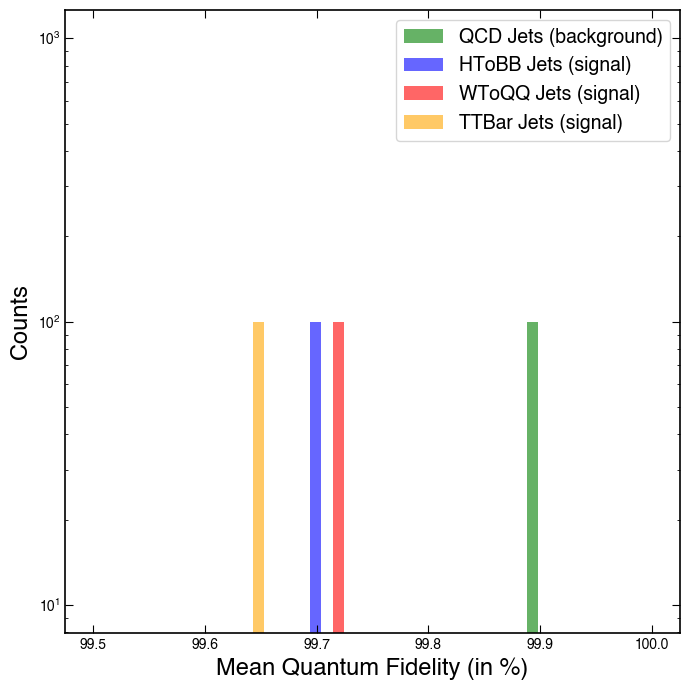

In [ ]:
means_HToBB = []
means_WToQQ = []
means_TTBar = []
means_back = []
median_HToBB = []   
median_WToQQ = []
median_TTBar = []
median_back = []

for i in range(100):
    means_back.append(np.mean(fil_100_back_3[i]))
    means_HToBB.append(np.mean(fil_100_HToBB_3[i]))
    means_WToQQ.append(np.mean(fil_100_WToQQ_3[i]))
    means_TTBar.append(np.mean(fil_100_TTBar_3[i]))
    median_back.append(np.median(fil_100_back_3[i]))
    
    median_HToBB.append(np.median(fil_100_HToBB_3[i]))
    median_WToQQ.append(np.median(fil_100_WToQQ_3[i]))
    median_TTBar.append(np.median(fil_100_TTBar_3[i]))
    median_back.append(np.median(fil_100_back_3[i]))

In [ ]:
print("Anomaly Score BACKGROUND:", 1 - np.min(means_back)/100)

print("Estadísticas de las fidelidades medias para HToBB:")
print("Media:", np.mean(means_HToBB))
print("Mediana:", np.median(median_HToBB))
print("Mínimo:", np.min(means_HToBB))
print("Máximo:", np.max(means_HToBB))
print("Desviación estándar sobre medias:", np.std(means_HToBB))
print("Desviación estándar sobre medianas:", np.std(median_HToBB))
print("Anomaly Score:", 1 - np.min(means_HToBB)/100)
print()
print("Estadísticas de las fidelidades medias para WToQQ:")
print("Media:", np.mean(means_WToQQ))
print("Mediana:", np.median(median_WToQQ))
print("Mínimo:", np.min(means_WToQQ))
print("Máximo:", np.max(means_WToQQ))
print("Desviación estándar sobre medias:", np.std(means_WToQQ))
print("Desviación estándar sobre medianas:", np.std(median_WToQQ))
print("Anomaly Score:", 1 - np.min(means_WToQQ)/100)
print()
print("Estadísticas de las fidelidades medias para TTBar:")
print("Media:", np.mean(means_TTBar))
print("Mediana:", np.median(median_TTBar))
print("Mínimo:", np.min(means_TTBar))
print("Máximo:", np.max(means_TTBar))   
print("Desviación estándar:", np.std(means_TTBar))
print("Anomaly Score:", 1 - np.min(means_TTBar)/100)

print("Difereferenicas entre medias")
print("HToBB - WToQQ:", np.mean(means_HToBB) - np.mean(means_WToQQ))
print("HToBB - TTBar:", np.mean(means_HToBB) - np.mean(means_TTBar))
print("WToQQ - TTBar:", np.mean(means_WToQQ) - np.mean(means_TTBar))

print("Difereferenicas entre medianas")
print("HToBB - WToQQ:", np.median(median_HToBB) - np.median(median_WToQQ))
print("HToBB - TTBar:", np.median(median_HToBB) - np.median(median_TTBar))
print("WToQQ - TTBar:", np.median(median_WToQQ) - np.median(median_TTBar))

Anomaly Score BACKGROUND: 0.0010520206808226629
Estadísticas de las fidelidades medias para HToBB:
Media: 99.69852846090576
Mediana: 99.99105494152732
Mínimo: 99.69793201571835
Máximo: 99.69885487682242
Desviación estándar: 0.00013658116162469237
Anomaly Score: 0.0030206798428165094

Estadísticas de las fidelidades medias para WToQQ:
Media: 99.72120234730723
Mediana: 99.99331755151542
Mínimo: 99.720596518715
Máximo: 99.72145862370854
Desviación estándar: 0.00011474532529917537
Anomaly Score: 0.0027940348128500103

Estadísticas de las fidelidades medias para TTBar:
Media: 99.64595287030266
Mediana: 99.98349021753519
Mínimo: 99.64536649937864
Máximo: 99.64635983978388
Desviación estándar: 0.00016204809547712583
Anomaly Score: 0.0035463350062135968
Difereferenicas entre medias
HToBB - WToQQ: -0.022673886401463506
HToBB - TTBar: 0.05257559060309802
WToQQ - TTBar: 0.07524947700456153
Difereferenicas entre medianas
HToBB - WToQQ: -0.0022626099880938
HToBB - TTBar: 0.007564723992132372
WToQQ 

In [ ]:
data = np.load('./fidelidades_100.npz', allow_pickle=True)
fil_100_back_4auc= data['fil_100_back_S']
fil_100_HToBB_4auc = data['fil_100_HToBB_S']
fil_100_WToQQ_4auc = data['fil_100_WToQQ_S']
fil_100_TTBar_4auc = data['fil_100_TTBar_S']

In [ ]:
auc_HToBB_list = []
auc_TTBar_list = []
auc_WToQQ_list = []

fil_100_back_4auc = fil_100_back_4auc.squeeze()
fil_100_HToBB_4auc = fil_100_HToBB_4auc.squeeze()
fil_100_WToQQ_4auc = fil_100_WToQQ_4auc.squeeze()
fil_100_TTBar_4auc = fil_100_TTBar_4auc.squeeze()

for i in range(100):
    event_fidelities_back = fil_100_back_4auc[i]
    event_fidelities_HToBB = fil_100_HToBB_4auc[i]
    event_fidelities_TTBar = fil_100_TTBar_4auc[i]
    event_fidelities_WToQQ = fil_100_WToQQ_4auc[i]

    # --- Anomaly scores (1 - Fidelity) ---
    anomaly_scores_back = 1 - np.array(event_fidelities_back).ravel()
    anomaly_scores_HToBB = 1 - np.array(event_fidelities_HToBB).ravel()
    anomaly_scores_TTBar = 1 - np.array(event_fidelities_TTBar).ravel()
    anomaly_scores_WToQQ = 1 - np.array(event_fidelities_WToQQ).ravel() 

    # --- Calcular AUC ---
    auc_HToBB = roc_auc_score(
        np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_HToBB)]),
        np.concatenate([anomaly_scores_back, anomaly_scores_HToBB])
    )

    auc_TTBar = roc_auc_score(
        np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_TTBar)]),
        np.concatenate([anomaly_scores_back, anomaly_scores_TTBar])
    )

    auc_WToQQ = roc_auc_score(
        np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_WToQQ)]),
        np.concatenate([anomaly_scores_back, anomaly_scores_WToQQ])
    )

    auc_HToBB_list.append(auc_HToBB)
    auc_TTBar_list.append(auc_TTBar)
    auc_WToQQ_list.append(auc_WToQQ)

#medias de AUCs
mean_auc_HToBB = np.mean(auc_HToBB_list)
mean_auc_TTBar = np.mean(auc_TTBar_list)
mean_auc_WToQQ = np.mean(auc_WToQQ_list)


print("Mean AUC HToBB:", mean_auc_HToBB)
print("Mean AUC TTBar:", mean_auc_TTBar)
print("Mean AUC WToQQ:", mean_auc_WToQQ)
print("Std AUC HToBB:", np.std(auc_HToBB_list))
print("Std AUC TTBar:", np.std(auc_TTBar_list))
print("Std AUC WToQQ:", np.std(auc_WToQQ_list))

Mean AUC HToBB: 0.7003041905
Mean AUC TTBar: 0.7890799033999998
Mean AUC WToQQ: 0.6482334243000001
Std AUC HToBB: 3.6216687797182165e-06
Std AUC TTBar: 3.166291275285535e-06
Std AUC WToQQ: 3.3007757436707747e-06
